<a href="https://colab.research.google.com/github/marinba2200/DL_test/blob/main/Aidea_AOI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 匯入資料與預處理

In [ ]:
#from google.colab import drive #執行這個後點網址可以登入google，登入後會顯示authorization code，再輸入到下面框框
#drive.mount('/content/drive/')

In [ ]:
#import os #連上雲端硬碟

#os.chdir("/content/drive/My Drive/Colab Notebooks/dataset/Aidea/AOI") #可自行在Colab Notebooks後方更改路徑
#os.getcwd() #查看當前路徑

In [ ]:
from google_drive_downloader import GoogleDriveDownloader


GoogleDriveDownloader.download_file_from_google_drive(file_id='1KFBwdC7dSP6yP41QEKshY2KWfQEWdyc2', dest_path='./content', unzip=True)
#GoogleDriveDownloader.download_file_from_google_drive(file_id='1KukPwlRjyYGeIc0PD_yl_Wv-aGPJr_vn',dest_path='./content', unzip=True)
#GoogleDriveDownloader.download_file_from_google_drive(file_id='1SRcwKSQZuTJw0s3H4EiZ9jPih68nlKcg',dest_path='./content', unzip=True)

# https://drive.google.com/file/d/1KFBwdC7dSP6yP41QEKshY2KWfQEWdyc2/view?usp=sharing
# https://drive.google.com/file/d/1KukPwlRjyYGeIc0PD_yl_Wv-aGPJr_vn/view?usp=sharing #對檔案使用共用，只取/d後方的直到下一個/
# https://drive.google.com/file/d/1SRcwKSQZuTJw0s3H4EiZ9jPih68nlKcg/view?usp=sharing

# https://drive.google.com/file/d/1hndFQbBqIxe8XvXW4MFihDIys5KDzwkf/view?usp=sharing

Unzipping...Done.


In [ ]:
import pandas as pd
df_train = pd.read_csv("train.csv",dtype=str)#必須是字串(為了generator用)
df_test = pd.read_csv("test.csv", dtype=str)#必須是字串(為了generator用)

print(df_train.shape)
print(df_test.shape)

(2528, 2)
(10142, 2)


In [ ]:
df_train.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [ ]:
train_files = df_train.iloc[:, 0].values #將ID與label分開
train_labels = df_train.iloc[:, 1].values

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


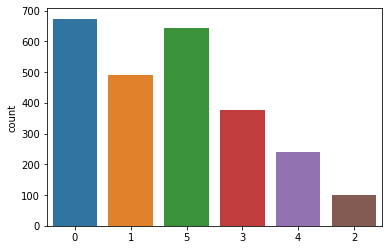

In [ ]:
import seaborn as sns
g = sns.countplot(train_labels)

In [ ]:
import numpy as np
labels, counts = np.unique(train_labels, return_counts=True)
print(labels, counts)

['0' '1' '2' '3' '4' '5'] [674 492 100 378 240 644]


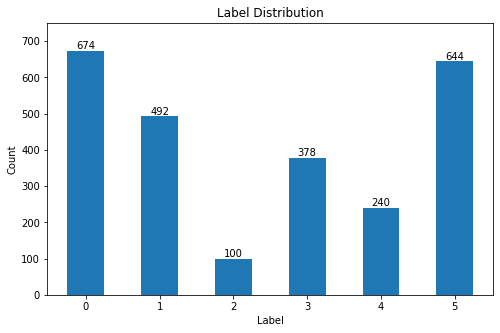

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 5))
plt.bar(labels, counts, width=0.5, align='center')
plt.title("Label Distribution")
plt.xlabel('Label')
plt.ylabel('Count')
# plt.xticks(labels)
plt.ylim(0, 750)
for a, b in zip(labels, counts):
    plt.text(a, b, '%d' % b, ha='center', va='bottom', fontsize=10)
plt.show()

### 開始架網路

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

In [ ]:
#the InceptionV3 model 
num_classes = 6
from tensorflow.keras.applications import InceptionV3 #使用googleNet
base_model = InceptionV3(include_top = False, input_shape=(299,299,3), weights='imagenet', classes=num_classes) 
# 不要最後一層(想自訂)，weight保留
base_model.summary() #210827184就是我們鎖住的網路部分

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
base_model.trainable = False #關掉trainable
last_layer = base_model.output #開始自訂output
last_layer = Flatten()(last_layer)
last_layer = Dropout(0.3)(last_layer)
out = Dense(num_classes, activation='softmax', name='softmax')(last_layer) #最後一個layer,num_classes是輸出的個數(6類)
custom_model = Model(base_model.input, out)
custom_model.summary() #這裡沒有trainable的部分就是我們剛剛鎖住的部分

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#from tensorflow.keras.applications import InceptionV3
#model = InceptionV3(include_top = True, input_shape=(299,299,3), weights=None, classes=num_classes) 
#include_top是要不要最後一層，沒有input weight 所以要從頭開始train，classes是output的資料型態

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input 
#keras給予的模型都是不同模式的(有tensorflow、caffe等等)，所以資料愈處理方式都不同(分布不同)，所以我們可以再設定(網路上可以找)
#xception是tensorflow的一種資料模式
img_gen = ImageDataGenerator(horizontal_flip=False, vertical_flip=False, preprocessing_function=preprocess_input)

In [ ]:
train_generator = img_gen.flow_from_dataframe(dataframe=df_train, #要將train的csv(label)跟影像(zip的)結合，變成我們需要的格式。
            directory="train_images",   #影像
            x_col="ID",          #影像檔名(必須是字串)
            y_col="Label",        #影像label(必須是字串)
            subset=None,         #target跟非target是否分開
            batch_size=8,
            shuffle=False,
            class_mode="categorical",
            color_mode="rgb",
            target_size=(299,299))

test_generator = img_gen.flow_from_dataframe(dataframe=df_test,
            directory="test_images",
            x_col="ID",
            y_col="Label",
            batch_size=32,
            shuffle=False,
            class_mode=None,
            target_size=(299, 299))

# If class_mode="categorical", y_col="Label" column values must be type string, list or tuple.

Found 2528 validated image filenames belonging to 6 classes.
Found 10142 validated image filenames.


In [ ]:
# Include the epoch in the file name (uses `str.format`)
import tensorflow as tf
import os

checkpoint_path = "training_cp/cp-{epoch:03d}.ckpt"  
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True) #儲存所有weight

In [ ]:
# Create a callback that stop the model 
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5) #儲存最好的那個weight

In [ ]:
from tensorflow.keras import optimizers
custom_model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.Adam(lr=3e-3),
            metrics=['accuracy'])
#....

In [ ]:
#hist = custom_model.fit_generator(generator=train_generator, steps_per_epoch=316, callbacks=[cp_callback, es_callback], epochs=20)
hist = custom_model.fit_generator(generator=train_generator, steps_per_epoch=316, callbacks=[cp_callback, es_callback], epochs=100)
callbacks=[cp_callback, es_callback] #當執行到最好的時候就中斷

Epoch 1/100
  1/316 [..............................] - ETA: 30s - loss: 0.0000e+00 - accuracy: 1.0000

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


316/316 [==============================] - 13s 42ms/step - loss: 0.1177 - accuracy: 0.9984
Epoch 2/100
316/316 [==============================] - 14s 43ms/step - loss: 0.9940 - accuracy: 0.9913
Epoch 3/100
316/316 [==============================] - 13s 42ms/step - loss: 0.7649 - accuracy: 0.9937
Epoch 4/100
316/316 [==============================] - 14s 43ms/step - loss: 0.4722 - accuracy: 0.9964
Epoch 5/100
316/316 [==============================] - 13s 42ms/step - loss: 0.4611 - accuracy: 0.9960
Epoch 6/100
316/316 [==============================] - 13s 43ms/step - loss: 8.0164e-10 - accuracy: 1.0000
Epoch 7/100
316/316 [==============================] - 13s 42ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/100
316/316 [==============================] - 13s 42ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/100
316/316 [==============================] - 13s 42ms/step - loss: 0.3040 - accuracy: 0.9984
Epoch 10/100
316/316 [==============================] - 14s 43ms/step - l

In [ ]:
#custom_model.save("AOI-InceptionV3-1118(custom).h5")

### 訓練完成

儲存好model後再匯入，使用集成式學習(隨機森林投票)，這樣就有5個model，最後再將最好的答案放入csv檔。

腦瘤是NIFTI檔案格式(因為是段切面(水平面、矢狀面、冠狀面))

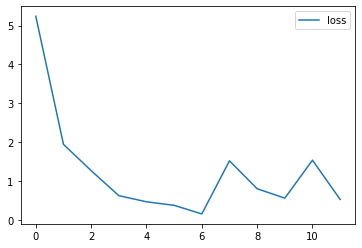

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='loss')
plt.legend()

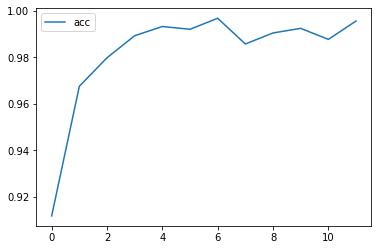

In [ ]:
# Plot accuracy per iteration
plt.plot(hist.history['accuracy'], label='acc')
plt.legend()

In [ ]:
##checkpoint 23
custom_model.load_weights("training_cp/cp-023.ckpt")
train_generator.reset()
custom_model.evaluate_generator(generator=train_generator, steps=316, verbose=1)

In [ ]:
##checkpoint 20 #選最好的結果來儲存W
#custom_model.load_weights("training_cp/cp-012.ckpt")
#train_generator.reset()
#custom_model.evaluate_generator(generator=train_generator, steps=316, verbose=1)

In [ ]:
train_generator.reset()
y_pred = custom_model.predict_generator(generator=train_generator, steps=316, verbose=1) #預測train

316/316 [==============================] - 14s 45ms/step


In [ ]:
print(y_pred[:2])
type(y_pred)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


numpy.ndarray

In [ ]:
import numpy as np #對結果做np處理，為了做混淆矩陣 不跑也沒差

predicts = np.argmax(y_pred,axis=1)
labels = train_labels.astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix #做混淆矩陣 不跑也沒差

confusion=confusion_matrix(labels, predicts)
print(confusion)

In [ ]:
overkill= []
underkill = []
for i in range(df_train.shape[0]):
  if labels[i] == 0 and predicts[i] !=0:
    overkill.append(i)
  if labels[i] != 0 and predicts[i] ==0:
    underkill.append(i)
print('# of overkill= {}; # of underkill= {} '.format(len(overkill), len(underkill)))

# of overkill= 0; # of underkill= 0 


In [ ]:
custom_model.load_weights("training_cp/cp-023.ckpt") #儲存model的weight，可以當候選人
custom_model.save("AOI-InceptionV3-1201_V1.h5") #儲存model，可以當候選人

In [ ]:
test_generator.reset() #可以反覆做的，找最佳測試準確度，每次可能不同
y_predt = custom_model.predict_generator(generator=test_generator, steps=317, verbose=1) #預測test(10142data/32batch=316...=~317)

317/317 [==============================] - 57s 180ms/step


In [ ]:
import numpy as np #儲存預測

predt = np.argmax(y_predt,axis=1)

df_out = pd.DataFrame(df_test)
df_out.shape

(10142, 2)

In [ ]:
df_out['Label'] = predt
df_out.to_csv("1201-Inception3_V1.csv", index=False) #將預測存成csv檔##最重要的##############################

### 開始生成影像

In [ ]:
import numpy as np

labels = train_labels.astype(int)

In [ ]:
from PIL import Image #生成新的影像(只做影像處理而已)，標籤0的不生成

train_path = "train_images/"
df_train2 = pd.DataFrame(df_train)
for file, label in zip(train_files, labels):
    img = Image.open(train_path+file)
    if label == 2 or label == 3 or label == 4:
        #flip image
        img_n1 = img.transpose(Image.FLIP_LEFT_RIGHT)
        file_n1 = file.replace(".png", "-h.png")
        img_n1.save(train_path+file_n1)
        new_row = {'ID':file_n1, 'Label':label}
        df_train2 = df_train2.append(new_row, ignore_index=True)#append row to the dataframe

        img_n2 = img.transpose(Image.FLIP_TOP_BOTTOM)
        file_n2 = file.replace(".png", "-v.png")
        img_n2.save(train_path+file_n2)
        new_row = {'ID':file_n2, 'Label':label}
        df_train2 = df_train2.append(new_row, ignore_index=True)#append row to the dataframe
    elif label == 1 or label == 5:
        img_n1 = img.transpose(Image.ROTATE_90)
        file_n1 = file.replace(".png", "-r1.png")
        img_n1.save(train_path+file_n1)
        new_row = {'ID':file_n1, 'Label':label}
        df_train2 = df_train2.append(new_row, ignore_index=True)#append row to the dataframe

        img_n2 = img.transpose(Image.ROTATE_180)
        file_n2 = file.replace(".png", "-r2.png")
        img_n2.save(train_path+file_n2)
        new_row = {'ID':file_n2, 'Label':label}
        df_train2 = df_train2.append(new_row, ignore_index=True)#append row to the dataframe
        
        img_n3 = img.transpose(Image.ROTATE_270)
        file_n3 = file.replace(".png", "-r3.png")
        img_n3.save(train_path+file_n3)
        new_row = {'ID':file_n3, 'Label':label}
        df_train2 = df_train2.append(new_row, ignore_index=True)#append row to the dataframe

print(df_train2.shape)

(7372, 2)


In [ ]:
df_train2.to_csv("train2.csv", index=False)

In [ ]:
import pandas as pd

df_train = pd.read_csv("train2.csv" , dtype=str)
print(df_train.shape)

(7372, 2)


In [ ]:
train_files = df_train.iloc[:, 0].values
train_labels = df_train.iloc[:, 1].values

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


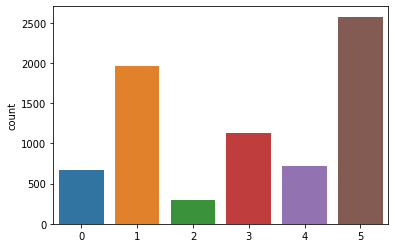

In [ ]:
import seaborn as sns

g = sns.countplot(train_labels, order=['0', '1', '2', '3', '4', '5'])

In [ ]:
train_generator = img_gen.flow_from_dataframe(dataframe=df_train, #再生成一次train
            directory="train_images",
            x_col="ID",
            y_col="Label",
            subset=None,
            batch_size=8,
            shuffle=False,
            class_mode="categorical",
            color_mode="rgb",
            target_size=(299, 299))

Found 7372 validated image filenames belonging to 6 classes.


In [ ]:
custom_model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.Adam(lr=3e-3),
            metrics=['accuracy'])

hist_1 = custom_model.fit_generator(generator=train_generator, steps_per_epoch=922, callbacks=[cp_callback, es_callback], epochs=100)

Epoch 1/100
922/922 [==============================] - 49s 53ms/step - loss: 3.0787 - accuracy: 0.9811
Epoch 2/100
922/922 [==============================] - 50s 54ms/step - loss: 1.2569 - accuracy: 0.9913
Epoch 3/100
922/922 [==============================] - 50s 54ms/step - loss: 1.5897 - accuracy: 0.9919
Epoch 4/100
922/922 [==============================] - 49s 53ms/step - loss: 0.4698 - accuracy: 0.9954
Epoch 5/100
922/922 [==============================] - 50s 54ms/step - loss: 0.1918 - accuracy: 0.9980
Epoch 6/100
922/922 [==============================] - 47s 51ms/step - loss: 1.0935 - accuracy: 0.9946
Epoch 7/100
922/922 [==============================] - 47s 51ms/step - loss: 0.9675 - accuracy: 0.9947
Epoch 8/100
922/922 [==============================] - 48s 52ms/step - loss: 0.5422 - accuracy: 0.9951
Epoch 9/100
922/922 [==============================] - 49s 53ms/step - loss: 0.1569 - accuracy: 0.9989
Epoch 10/100
922/922 [==============================] - 47s 51ms/step - l

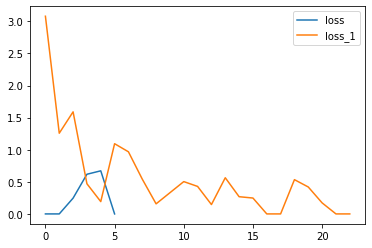

In [ ]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist_1.history['loss'], label='loss_1')
plt.legend()

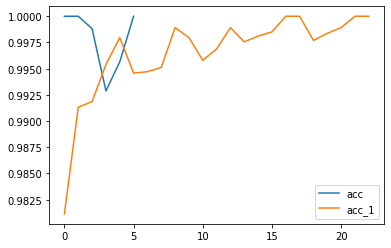

In [ ]:
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist_1.history['accuracy'], label='acc_1')
plt.legend()

### 使用先訓練好的網路

In [ ]:
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id='1sh735v1fkLU3EC-xZCIq6mmvYkKyRUq9',dest_path='./model', unzip=True)

In [ ]:
model_files = ['m1.h5', 'm2.h5', 'm3.h5']
models = []
for file in model_files:
  model = tf.keras.models.load_model(file)
  models.append(model)

In [ ]:
for model in models:
  print(model.name)

### 評估第二個網路

In [ ]:
for model in models:
    train_generator.reset()
    model.evaluate_generator(generator=train_generator, steps=922, verbose=1)

#for model in models:
#    test_generator.reset()
#    model.evaluate_generator(generator=test_generator, steps=317, verbose=1)

In [ ]:
y_predictions_All = []
for model in models:
    train_generator.reset()
    y_predictions = model.predict_generator(generator=train_generator, steps=922, verbose=1)
    y_predictions_All.append(y_predictions)

In [ ]:
labels = train_labels.astype(int)

from sklearn.metrics import confusion_matrix
predicts_all = []
for y_predictions in y_predictions_All:
    predicts = np.argmax(y_predictions,axis=1)
    predicts_all.append(predicts)
    confusion=confusion_matrix(labels, predicts)
    print(confusion)

In [ ]:
y_predictions_ensemble = y_predictions_All[0]+y_predictions_All[1]+y_predictions_All[2]
print(y_predictions_ensemble[:5])
type(y_predictions)

In [ ]:
predicts_ensemble = np.argmax(y_predictions_ensemble,axis=1)
print(predicts_ensemble[:5])

In [ ]:
confusion=confusion_matrix(labels, predicts_ensemble)
print(confusion)